Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

### Solution by Pablo Campos Viana
Information of the course can be found at:
https://www.udacity.com/course/deep-learning--ud730

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [5]:
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(np.argmax(predictions, 1), np.argmax(labels, 1))
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

print('Done')

Done


Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [6]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [7]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  test_error, confusions = error_rate(test_prediction.eval(), test_labels)
  print('Test error: %.1f%%' % test_error)

Initialized
Minibatch loss at step 0: 3.131751
Minibatch accuracy: 25.0%
Validation accuracy: 9.8%
Minibatch loss at step 50: 1.727024
Minibatch accuracy: 37.5%
Validation accuracy: 49.7%
Minibatch loss at step 100: 1.248853
Minibatch accuracy: 68.8%
Validation accuracy: 65.7%
Minibatch loss at step 150: 1.350484
Minibatch accuracy: 68.8%
Validation accuracy: 71.2%
Minibatch loss at step 200: 0.347279
Minibatch accuracy: 93.8%
Validation accuracy: 76.4%
Minibatch loss at step 250: 0.692960
Minibatch accuracy: 81.2%
Validation accuracy: 78.5%
Minibatch loss at step 300: 0.514370
Minibatch accuracy: 81.2%
Validation accuracy: 80.9%
Minibatch loss at step 350: 0.746137
Minibatch accuracy: 75.0%
Validation accuracy: 79.7%
Minibatch loss at step 400: 0.810778
Minibatch accuracy: 81.2%
Validation accuracy: 80.1%
Minibatch loss at step 450: 0.727286
Minibatch accuracy: 75.0%
Validation accuracy: 79.6%
Minibatch loss at step 500: 0.628537
Minibatch accuracy: 81.2%
Validation accuracy: 81.7%
Mi

### Visualizing the confusion matrix

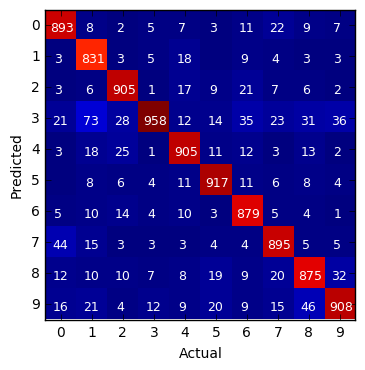

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_LABELS = 10

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (nn.max_pool()) of stride 2 and kernel size 2.

---

In [9]:
# Create image size function based on input, filter size, padding and stride
# 2 convolutions only
def output_size_no_pool(input_size, filter_size, padding, conv_stride):
    if padding == 'same':
        padding = -1.00
    elif padding == 'valid':
        padding = 0.00
    else:
        return None
    output_1 = float(((input_size - filter_size - 2*padding) / conv_stride) + 1.00)
    output_2 = float(((output_1 - filter_size - 2*padding) / conv_stride) + 1.00)
    return int(np.ceil(output_2))

patch_size = 5
final_image_size = output_size_no_pool(image_size, patch_size, padding='same', conv_stride=2)
print(final_image_size)

7


In [10]:
batch_size = 16
# Depth is the number of output channels 
# On the other hand, num_channels is the number of input channels set at 1 previously
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    '''Input data'''
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    '''Variables'''
    # Convolution 1 Layer
    # Input channels: num_channels = 1
    # Output channels: depth = 16
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    # Convolution 2 Layer
    # Input channels: depth = 16
    # Output channels: depth = 16
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    # Fully Connected Layer (Densely Connected Layer)
    # Use neurons to allow processing of entire image
    layer3_weights = tf.Variable(tf.truncated_normal([final_image_size * final_image_size * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    # Readout layer: Softmax Layer
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    '''Model'''
    def model(data):
        # First Convolutional Layer with Pooling
        conv_1 = tf.nn.conv2d(data, layer1_weights, strides=[1, 1, 1, 1], padding='SAME')
        hidden_1 = tf.nn.relu(conv_1 + layer1_biases)
        pool_1 = tf.nn.max_pool(hidden_1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
        # Second Convolutional Layer with Pooling
        conv_2 = tf.nn.conv2d(pool_1, layer2_weights, strides=[1, 1, 1, 1], padding='SAME')
        hidden_2 = tf.nn.relu(conv_2 + layer2_biases)
        pool_2 = tf.nn.max_pool(hidden_2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
        # Full Connected Layer
        shape = pool_2.get_shape().as_list()
        reshape = tf.reshape(pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
        # Readout Layer: Softmax Layer
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    '''Training computation'''
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    '''Optimizer'''
    # Learning rate of 0.05
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    '''Predictions for the training, validation, and test data'''
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [11]:
num_steps = 30000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 5000 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    test_error, confusions = error_rate(test_prediction.eval(), test_labels)
    print('Test error: %.1f%%' % test_error)

Initialized
Minibatch loss at step 0: 3.560715
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 5000: 0.434720
Minibatch accuracy: 87.5%
Validation accuracy: 88.6%
Minibatch loss at step 10000: 0.200951
Minibatch accuracy: 93.8%
Validation accuracy: 89.9%
Minibatch loss at step 15000: 0.044204
Minibatch accuracy: 100.0%
Validation accuracy: 90.1%
Minibatch loss at step 20000: 0.068061
Minibatch accuracy: 93.8%
Validation accuracy: 89.7%
Minibatch loss at step 25000: 0.269498
Minibatch accuracy: 87.5%
Validation accuracy: 90.6%
Test accuracy: 96.0%
Test error: 4.0%


### Visualizing the confusion matrix

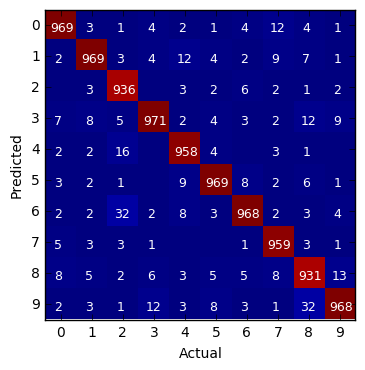

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_LABELS = 10

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

###  Network Architecture

* image_size = 28
* Convolutions
    * conv_filter_size = 5
    * conv_stride = 1
* Average Pooling
    * pool_filter_size = 2
    * pool_stride = 2
* padding='valid'
* To prevent overfitting
    * Learning rate decay
    * L2 Regularization
    * Dropout
* Layers
    * Convolution
    * Pooling
    * Convolution
    * Pooling
    * First Fully-connected
    * Second Fully-connected

In [13]:
image_size = 28
# Create image size function based on input, filter size, padding and stride
# 2 convolutions only with 2 pooling
def output_size_pool(input_size, conv_filter_size, pool_filter_size, padding, conv_stride, pool_stride):
    if padding == 'same':
        padding = -1.00
    elif padding == 'valid':
        padding = 0.00
    else:
        return None
    # After convolution 1
    output_1 = (((input_size - conv_filter_size - 2*padding) / conv_stride) + 1.00)
    # After pool 1
    output_2 = (((output_1 - pool_filter_size - 2*padding) / pool_stride) + 1.00)    
    # After convolution 2
    output_3 = (((output_2 - conv_filter_size - 2*padding) / conv_stride) + 1.00)
    # After pool 2
    output_4 = (((output_3 - pool_filter_size - 2*padding) / pool_stride) + 1.00)  
    return int(output_4)

final_image_size = output_size_pool(input_size=image_size, conv_filter_size=5, pool_filter_size=2, padding='valid', conv_stride=1, pool_stride=2)
print(final_image_size)

4


In [14]:
batch_size = 16
# Depth is the number of output channels 
# On the other hand, num_channels is the number of input channels set at 1 previously
depth = 32
num_hidden = 64
beta = 0.001

graph = tf.Graph()

with graph.as_default():

    '''Input data'''
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    '''Variables'''
    # Convolution 1 Layer
    # Input channels: num_channels = 1
    # Output channels: depth = 16
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    # Convolution 2 Layer
    # Input channels: depth = 16
    # Output channels: depth = 16
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    # First Fully Connected Layer (Densely Connected Layer)
    # Use neurons to allow processing of entire image
    final_image_size = output_size_pool(input_size=image_size, conv_filter_size=5, pool_filter_size=2, padding='valid', conv_stride=1, pool_stride=2)
    layer3_weights = tf.Variable(tf.truncated_normal([final_image_size * final_image_size * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    # Second Fully Connected Layer
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_hidden], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    # Readout layer: Softmax Layer
    layer5_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    '''Model'''
    def model(data):
        # First Convolutional Layer with Pooling
        conv_1 = tf.nn.conv2d(data, layer1_weights, strides=[1, 1, 1, 1], padding='VALID')
        hidden_1 = tf.nn.relu(conv_1 + layer1_biases)
        pool_1 = tf.nn.avg_pool(hidden_1, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        
        # Second Convolutional Layer with Pooling
        conv_2 = tf.nn.conv2d(pool_1, layer2_weights, strides=[1, 1, 1, 1], padding='VALID')
        hidden_2 = tf.nn.relu(conv_2 + layer2_biases)
        pool_2 = tf.nn.avg_pool(hidden_2, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        
        # First Fully Connected Layer
        shape = pool_2.get_shape().as_list()
        reshape = tf.reshape(pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        keep_prob = 0.5
        hidden_drop = tf.nn.dropout(hidden, keep_prob)
        
        # Second Fully Connected Layer
        hidden_2 = tf.nn.relu(tf.matmul(hidden_drop, layer4_weights) + layer4_biases)
        hidden_2_drop = tf.nn.dropout(hidden_2, keep_prob)
        
        # Readout Layer: Softmax Layer
        return tf.matmul(hidden_2_drop, layer5_weights) + layer5_biases

    '''Training computation'''
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    # Loss function with L2 Regularization 
    regularizers = tf.nn.l2_loss(layer4_weights) + \
                    tf.nn.l2_loss(layer5_weights)
    loss = tf.reduce_mean(loss + beta * regularizers)

    '''Optimizer'''
    # Decaying learning rate
    global_step = tf.Variable(0)  # count the number of steps taken.
    start_learning_rate = 0.05
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    '''Predictions for the training, validation, and test data'''
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [15]:
num_steps = 30000

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 5000 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    test_error, confusions = error_rate(test_prediction.eval(), test_labels)
    print('Test error: %.1f%%' % test_error)

Initialized
Minibatch loss at step 0: 4.512135
Minibatch accuracy: 6.2%
Validation accuracy: 10.6%
Minibatch loss at step 5000: 0.525560
Minibatch accuracy: 81.2%
Validation accuracy: 82.2%
Minibatch loss at step 10000: 0.463509
Minibatch accuracy: 87.5%
Validation accuracy: 84.8%
Minibatch loss at step 15000: 0.217212
Minibatch accuracy: 93.8%
Validation accuracy: 84.8%
Minibatch loss at step 20000: 0.259874
Minibatch accuracy: 93.8%
Validation accuracy: 86.1%
Minibatch loss at step 25000: 0.256523
Minibatch accuracy: 93.8%
Validation accuracy: 86.2%
Test accuracy: 93.1%
Test error: 7.1%


### Visualizing the confusion matrix

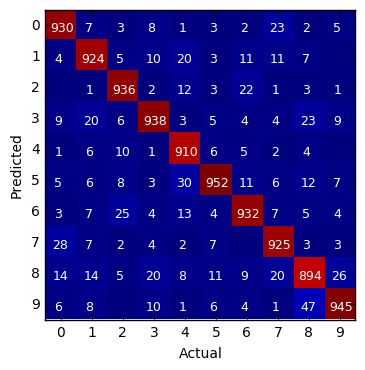

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_LABELS = 10

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')